# Исследование рисков ДТП по выбранному маршруту движения

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.


**Идея решения задачи от заказчика:**

1) Создать модель предсказания ДТП (целевое значение — **at_fault (виновник) в таблице parties**)

        - Для модели выбрать тип виновника — только машина (car).
        
        - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

        - Для моделирования ограничиться данными за 2012 год — они самые свежие.

        - Обязательное условие — учесть фактор возраста автомобиля.
        
2) На основе модели исследовать основные факторы ДТП.

3) Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

        - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
        
        - Какие ещё факторы нужно учесть?
        
        - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
        
        - Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 
        
        
Необходимо провести собственное исследование и подготовить гипотезы связей происшествий

## Загрузка библиотек

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
import torch
import torch.nn as nn
from tqdm import tqdm

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV,
                                    RandomizedSearchCV)


from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (recall_score,
                            confusion_matrix,
                            precision_score,
                            precision_recall_curve)
    


## Подключение к базе

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)



In [5]:
engine = create_engine(connection_string) #создание подключения

## Первичное исследование таблиц

### collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [6]:
# напишем запрос
query = '''
SELECT * 

FROM collisions

'''

# выполним запрос
collisions = pd.read_sql_query(query, con=engine)
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399995,4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
1399996,4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
1399997,4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00
1399998,4083008,4313,santa clara,20.0,east,NaN,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-06,17:53:00


In [7]:
#функция вывода на экран количественного и процентного содержания пропусков в столбцах датафрейма:

def nulli(df):
    # Создадим новый датафрейм nulls_report с количественным содержанием пропусков:
    nulls_report = df.isna().sum().to_frame()
    # Изменим название столбца 0 на 'missing_values':
    nulls_report = nulls_report.rename(columns={0: 'missing_values'})
    # Добавим столбец 'percent_of_missing_values' с процентным содержанием пропусков, округлённых до тысячных:
    nulls_report['percent_of_missing_values'] = round(nulls_report['missing_values'] / df.shape[0], 3) * 100
    # Выведем получившийся датафрейм на экран:
    return nulls_report.sort_values('missing_values', ascending=False)

In [8]:
#применим функцию и найдем пропуски
print(nulli(collisions))

                             missing_values  percent_of_missing_values
location_type                        881221                       62.9
direction                            340642                       24.3
pcf_violation_category                27954                        2.0
road_surface                          13093                        0.9
collision_time                        12308                        0.9
intersection                          12219                        0.9
road_condition_1                      11988                        0.9
type_of_collision                     11824                        0.8
lighting                               8593                        0.6
control_device                         8407                        0.6
primary_collision_factor               8166                        0.6
weather_1                              7259                        0.5
motor_vehicle_involved_with            6819                        0.5
county

### parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

In [9]:
# напишем запрос
query = '''
SELECT * 

FROM parties

'''

# выполним запрос
parties = pd.read_sql_query(query, con=engine)
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
2752403,1549682,4981212,2,building,0,22.0,had not been drinking,None,NaN
2752404,1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0
2752405,1906386,5181692,1,building,1,5.0,had not been drinking,None,0.0
2752406,2403824,5453437,2,building,0,30.0,had not been drinking,None,0.0


In [10]:
#применим функцию и найдем пропуски
print(nulli(parties))

                     missing_values  percent_of_missing_values
party_drug_physical         2320120                       84.3
cellphone_in_use             511637                       18.6
insurance_premium            405402                       14.7
party_sobriety                73955                        2.7
party_type                     3622                        0.1
id                                0                        0.0
case_id                           0                        0.0
party_number                      0                        0.0
at_fault                          0                        0.0


### vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

In [11]:
# напишем запрос
query = '''
SELECT * 

FROM vehicles

'''

# выполним запрос
vehicles = pd.read_sql_query(query, con=engine)
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...,...
1021229,1175684,5304990,2,sedan,manual,6.0
1021230,1175686,5304993,2,sedan,manual,3.0
1021231,1175687,5304994,2,sedan,manual,3.0
1021232,1175693,5305002,1,sedan,manual,5.0


In [12]:
#применим функцию и найдем пропуски
print(nulli(vehicles))

                      missing_values  percent_of_missing_values
vehicle_age                    24582                        2.4
vehicle_transmission           23659                        2.3
id                                 0                        0.0
case_id                            0                        0.0
party_number                       0                        0.0
vehicle_type                       0                        0.0


### Выводы по анализу таблиц

**Краткое описание таблиц**


1) collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.


2) parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.


3) vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.


Все таблицы имеют набор данных, таблицы имеют разный процент пропусков, больше всего наблюдается в табицах collisions и parties. Количество признаков в каждой таблице совпадает с заявленным.

##  Статистический анализ факторов ДТП

1) Посмотрим, в какие месяцы происходит наибольшее количество аварий для всего периода наблюдений

Проверим количество аварий по месяцам для каждого года. Не везде могут присутсвовать данные за определенный месяц, поэтому корректнее будет посмотреть по годам

Посмотрим годы, за которые есть информация

In [13]:
# напишем запрос
query = '''
SELECT EXTRACT(YEAR FROM collision_date::date) AS year_date, EXTRACT(MONTH FROM collision_date::date) AS month_date, COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date::date), EXTRACT(MONTH FROM collision_date::date) 
ORDER BY EXTRACT(YEAR FROM collision_date::date) ASC, EXTRACT(MONTH FROM collision_date::date) ASC
'''

# выполним запрос
collisions_month = pd.read_sql_query(query, con=engine)
collisions_month

,year_date,month_date,total_collisions
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916
5,2009.0,6.0,34202
6,2009.0,7.0,35161
7,2009.0,8.0,34508
8,2009.0,9.0,35555
9,2009.0,10.0,37835


Исключим 2013 и 2020 год и посмотрим

In [14]:
# напишем запрос
query = '''
SELECT EXTRACT(MONTH FROM collision_date::date) AS month_date, COUNT(case_id) AS total_collisions
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date::date) != 2013 AND EXTRACT(YEAR FROM collision_date::date) != 2020
GROUP BY EXTRACT(MONTH FROM collision_date::date)
ORDER BY total_collisions DESC
'''

# выполним запрос
collisions_month = pd.read_sql_query(query, con=engine)
collisions_month

,month_date,total_collisions
0,3.0,139534
1,1.0,131900
2,5.0,130316
3,4.0,130175
4,2.0,128750
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


In [15]:
# напишем запрос
query = '''
SELECT EXTRACT(MONTH FROM collision_date::date) AS month_date, COUNT(case_id) AS total_collisions
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date::date) != 2013 AND EXTRACT(YEAR FROM collision_date::date) != 2020
GROUP BY EXTRACT(MONTH FROM collision_date::date)
ORDER BY month_date ASC
'''

# выполним запрос
collisions_month = pd.read_sql_query(query, con=engine)

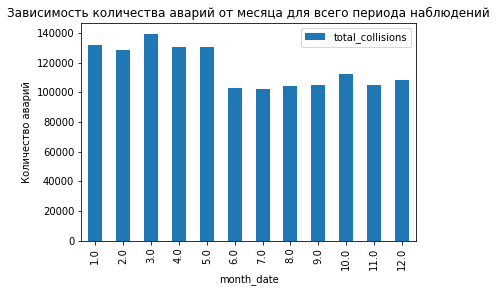

In [16]:
collisions_month.plot(x='month_date', kind = 'bar', title = 'Зависимость количества аварий от месяца для всего периода наблюдений', ylabel = 'Количество аварий')
plt.show()

Визуально кажется, что количество аварий не сильно отличается по месяцам, однако наибольшее колчиество аварий наблюдается в марте, январе. Это можно объяснить тем, что в марте начинается слякоть и таяние снега, дорога начинает скользить, также можно связать психологические факторы начала весны и некого "обострения" у людей. В январе увеличенное количество аварий может быть из-за новогодних праздников и нетрезвости.

**Также необходимо ответить на следующие вопросы для понимания данных:**

Для каждого пункта необходимо построить sql-запрос, вывести таблицу, а также построить визуализацию и сделать вывод

2) Необходимо посмотреть количество аварий в разные погодные условия

3) Посмотреть количество серьезных (1 и 2 тип) аварий в зависимости от месяца или квартала

4) Посмотреть количество серьезных (1 и 2 тип) аварий в зависимости от разных погодных условий

5) количество серьезных (1 и 2 тип) аварий в зависимости от дорожного состояния

6) Посмотреть, какие факторы аварий встречаются чаще всего

7) Посмотреть зависимость количества аварий(для всех типов серьезности аварий по отдельности) от освещенности дороги

8) Связь типа аварии и серьезности аварии

9) Связь типов участников происществия(parties) и серьезности аварии, также количество аварий на каждый тип участников

10) Зависимость виновности в аварии от типа участника(количество для каждого типа участника)

11) Зависимость количества виновных в аварии от состояния участника

12) Зависимость количества  виновных в аварии от трезвости участника

13) Посмотреть процент трезвых аварий к общему числу аварий

14) Зависимость количества аварий и возраста автомобиля

15) Количество виновных и невиновных аварий для каждого возраста автомобиля

16) Посмотрим количество аварий и количество виновных в авариях для каждого вида повреждения автомобиля, а также процент виновных

In [17]:
# напишем запрос
query = '''

SELECT *, total_fault/total_damage AS procent_fault
FROM (SELECT c.collision_damage, COUNT(p.at_fault) AS total_damage, SUM(p.at_fault)::numeric AS total_fault
      FROM collisions AS c
      INNER JOIN parties AS p ON c.case_id = p.case_id
      GROUP BY c.collision_damage) as d

'''

# выполним запрос
fault_damage = pd.read_sql_query(query, con=engine)
fault_damage

,collision_damage,total_damage,total_fault,procent_fault
0,fatal,19954,10138.0,0.508069
1,middle damage,315932,155293.0,0.491539
2,scratch,734188,324280.0,0.441685
3,severe damage,56335,28744.0,0.510233
4,small damage,1625999,769672.0,0.473353


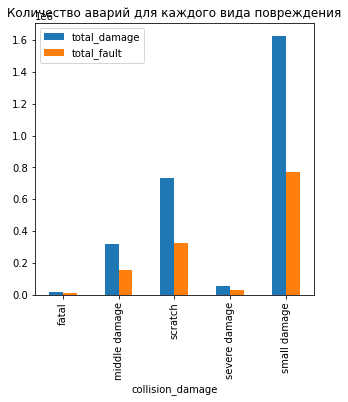

In [18]:

fault_damage[['collision_damage', 'total_damage', 'total_fault']].plot(x='collision_damage', kind='bar', figsize = (5,5), title = 'Количество аварий для каждого вида повреждения') 
plt.show()

17) посмотрим количество аварий и количество виновных в авариях для фатального повреждения для разных состояний трезвости

In [19]:
# напишем запрос
query = '''

SELECT p.PARTY_SOBRIETY, COUNT(p.case_id) AS total_damage, SUM(p.at_fault) AS total_fault 
FROM collisions AS c
INNER JOIN parties AS p ON c.case_id = p.case_id
WHERE c.collision_damage = 'fatal'
GROUP BY p.PARTY_SOBRIETY

'''

# выполним запрос
fault_sobriety_damage = pd.read_sql_query(query, con=engine)
fault_sobriety_damage

,party_sobriety,total_damage,total_fault
0,"had been drinking, impairment unknown",436,319
1,"had been drinking, not under influence",368,207
2,"had been drinking, under influence",3681,3174
3,had not been drinking,12263,5013
4,impairment unknown,1871,1058
5,not applicable,674,17
6,None,661,350


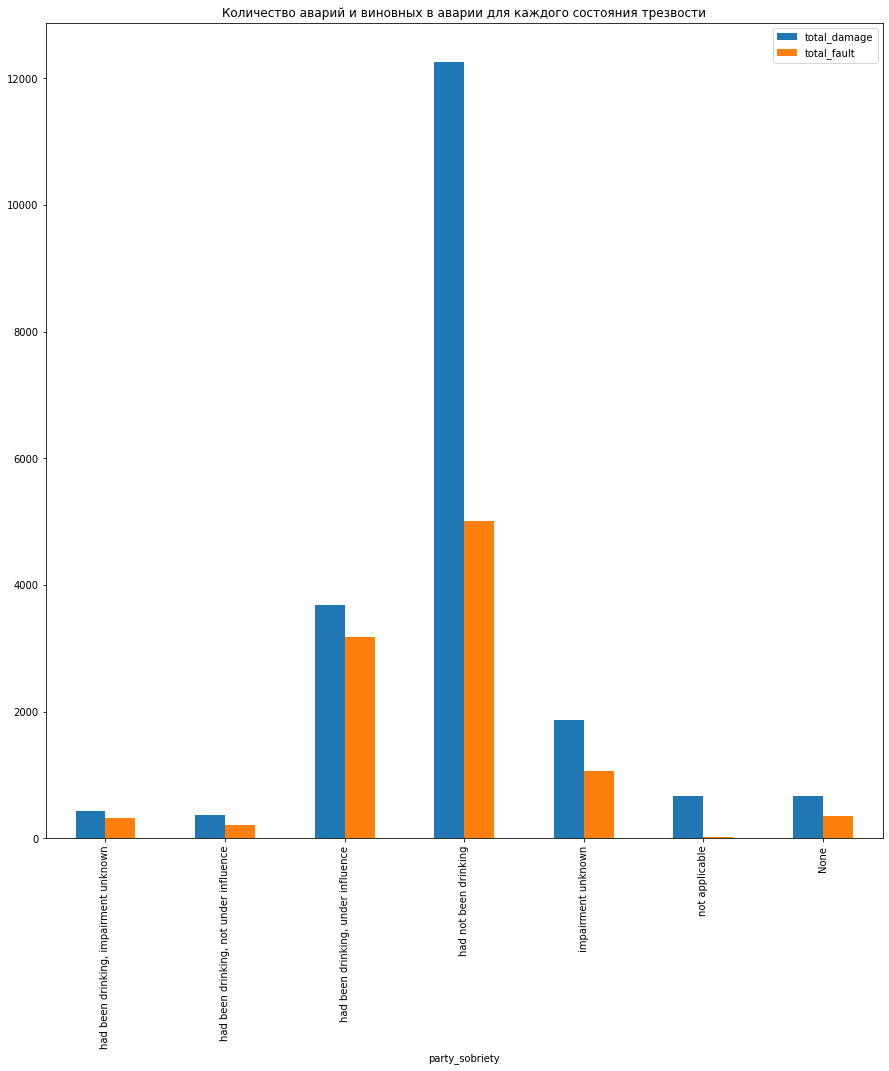

In [20]:
fault_sobriety_damage[['party_sobriety','total_damage', 'total_fault']].plot(x='party_sobriety', kind='bar', figsize = (15,15), title = 'Количество аварий и виновных в аварии для каждого состояния трезвости') 
plt.show()

Видно, что хоть и трезвых фатальных аварий больше, но процент виновных в аварии гораздо больше там, где человек выпил

## Подготовка данных для создания модели для оценки водительского риска

Здесь построим модель на основе изначального предположения заказчика.

 - Необходимо выбрать тип виновника — только машина (car)
 
 - Необходимо рассмотреть  случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина)
 
 - Для моделирования необходимо взять данные только за 2012 год
 
 - Подготовка исходной таблицы должна проводиться с помощью sql-запроса
 
**Для модели выберем следующие признаки:**
 
Для таблицы Collisions:
 
 - COLLISION_DATE
 - WEATHER_1
 - PRIMARY_COLL_FACTOR (Основной фактор аварии)
 - ROAD_SURFACE(Состояние дороги)
 - LIGHTING
 - COUNTY_LOCATION
 - LOCATION_TYPE (Тип дороги)
 - ROAD_CONDITION_1 (Дорожное состояние)
 
Для таблицы Parties:
 
 - AT_FAULT (Виновность участника) **Целевой признак**
 - PARTY_DRUG_PHYSICAL (Состояние участника)
 - PARTY_SOBRIETY (Трезвость участника)
 - CELLPHONE_IN_USE (Наличие телефона)
 
Для таблицы Vehicles:

 - VEHICLE_AGE (Возраст автомобиля)
 
 
 
Загружать будем данные аварий для каждого участника, таким образом уникальный идентификатор будет состоять из case_id и party_number


Для проверки работы моделей будем использовать метрику recall как полноту всех положительных выделенных моделью среди всех настоящих положительных. Именно эту метрику необходимо максимизировать бизнесу, потому что необходимо найти именно максимальное количество вероятных аварий

### Загрузка данных

In [21]:
# напишем запрос 
query = '''
SELECT EXTRACT(MONTH FROM c.collision_date),
       c.weather_1,
       c.primary_collision_factor,
       c.road_surface,
       c.lighting,
       c.county_location,
       c.road_condition_1,
       p.at_fault,
       p.party_sobriety,
       p.cellphone_in_use, 
       v.vehicle_age
       
FROM collisions AS c
INNER JOIN parties AS p ON c.case_id = p.case_id
INNER JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number

WHERE p.party_type = 'car' AND c.collision_damage != 'scratch' AND EXTRACT(YEAR FROM c.collision_date) = 2012




'''

# выполним запрос
data = pd.read_sql_query(query, con=engine)
data

,date_part,weather_1,primary_collision_factor,road_surface,lighting,county_location,road_condition_1,at_fault,party_sobriety,cellphone_in_use,vehicle_age
0,4.0,clear,vehicle code violation,None,daylight,los angeles,holes,0,had not been drinking,0.0,0.0
1,1.0,clear,vehicle code violation,dry,dark with street lights,contra costa,normal,0,had not been drinking,0.0,10.0
2,4.0,clear,vehicle code violation,dry,daylight,los angeles,normal,0,had not been drinking,NaN,8.0
3,4.0,clear,vehicle code violation,dry,dark with street lights,riverside,normal,0,had not been drinking,0.0,4.0
4,4.0,clear,vehicle code violation,dry,daylight,sacramento,normal,1,had not been drinking,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
56243,5.0,clear,vehicle code violation,dry,daylight,los angeles,normal,1,had not been drinking,0.0,9.0
56244,5.0,clear,vehicle code violation,dry,daylight,san diego,normal,1,had not been drinking,0.0,3.0
56245,6.0,None,unknown,dry,daylight,sutter,normal,0,had not been drinking,0.0,8.0
56246,1.0,clear,vehicle code violation,dry,daylight,sacramento,normal,0,had not been drinking,0.0,4.0


### Проверим данные на пропуски и аномалии

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_part                 56248 non-null  float64
 1   weather_1                 56080 non-null  object 
 2   primary_collision_factor  56137 non-null  object 
 3   road_surface              55900 non-null  object 
 4   lighting                  56094 non-null  object 
 5   county_location           56248 non-null  object 
 6   road_condition_1          55999 non-null  object 
 7   at_fault                  56248 non-null  int64  
 8   party_sobriety            55376 non-null  object 
 9   cellphone_in_use          51777 non-null  float64
 10  vehicle_age               54554 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.7+ MB


In [23]:
# Выведем на экран количественное и процентное содержание пропусков в столбцах датафрейма:
#применим функцию и найдем пропуски
print(nulli(data))

                          missing_values  percent_of_missing_values
cellphone_in_use                    4471                        7.9
vehicle_age                         1694                        3.0
party_sobriety                       872                        1.6
road_surface                         348                        0.6
road_condition_1                     249                        0.4
weather_1                            168                        0.3
lighting                             154                        0.3
primary_collision_factor             111                        0.2
date_part                              0                        0.0
county_location                        0                        0.0
at_fault                               0                        0.0


**Поработаем с vehicle_age** 

Заполним пропуск медианой значений

In [24]:
data['vehicle_age'] = data['vehicle_age'].fillna(data['vehicle_age'].median())

**Поработаем с cellphone_in_use**

Заполним чаще встречающимся значением

In [25]:
data['cellphone_in_use'].value_counts(normalize=True)

0.0    0.979643
1.0    0.020357
Name: cellphone_in_use, dtype: float64

In [26]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(0)

**Поработаем с party_sobriety**

In [27]:
data['party_sobriety'].value_counts(normalize=True)

had not been drinking                     0.877221
had been drinking, under influence        0.080811
impairment unknown                        0.022356
had been drinking, not under influence    0.010384
had been drinking, impairment unknown     0.004713
not applicable                            0.004515
Name: party_sobriety, dtype: float64

In [28]:
data['party_sobriety'] = data['party_sobriety'].fillna('unknow')

**Поработаем с road_surface**

In [29]:
data['road_surface'].value_counts(normalize=True)

dry         0.898784
wet         0.094061
snowy       0.006386
slippery    0.000769
Name: road_surface, dtype: float64

In [30]:
data['road_surface'] = data['road_surface'].fillna('dry')

**Поработаем с road_condition_1**

In [31]:
data['road_condition_1'].value_counts(normalize=True)

normal            0.965482
construction      0.017911
obstruction       0.004429
other             0.004072
holes             0.003964
loose material    0.002286
reduced width     0.001286
flooded           0.000571
Name: road_condition_1, dtype: float64

In [32]:
data['road_condition_1'] = data['road_condition_1'].fillna('normal')

**Поработаем с lighting**

In [33]:
data['lighting'].value_counts(normalize=True)

daylight                                   0.678575
dark with street lights                    0.196402
dark with no street lights                 0.091079
dusk or dawn                               0.031536
dark with street lights not functioning    0.002407
Name: lighting, dtype: float64

In [34]:
data['lighting'] = data['lighting'].fillna('unknow')

**Поработаем с primary_collision_factor**

In [35]:
data['primary_collision_factor'].value_counts(normalize=True)

vehicle code violation    0.960418
other than driver         0.020468
unknown                   0.015035
other improper driving    0.004026
fell asleep               0.000053
Name: primary_collision_factor, dtype: float64

In [36]:
data['primary_collision_factor'] = data['primary_collision_factor'].fillna('vehicle code violation')

**Поработаем с weather_1**

In [37]:
data['weather_1'].value_counts(normalize=True)

clear      0.804066
cloudy     0.150267
raining    0.038837
fog        0.003228
snowing    0.002800
other      0.000606
wind       0.000196
Name: weather_1, dtype: float64

In [38]:
data['weather_1'] = data['weather_1'].fillna('clear')

### Проверим дубликаты

In [39]:
#проверим полные дубликаты
print(data.duplicated().sum())

31829


In [40]:
data = data.drop_duplicates()

Данные в основном категориальные, а в количественных уже понятные значения, поэтому опустим проверку на выбросы

Данные чисты, можно приступать к дальнейшим шагам

In [41]:
data

,date_part,weather_1,primary_collision_factor,road_surface,lighting,county_location,road_condition_1,at_fault,party_sobriety,cellphone_in_use,vehicle_age
0,4.0,clear,vehicle code violation,dry,daylight,los angeles,holes,0,had not been drinking,0.0,0.0
1,1.0,clear,vehicle code violation,dry,dark with street lights,contra costa,normal,0,had not been drinking,0.0,10.0
2,4.0,clear,vehicle code violation,dry,daylight,los angeles,normal,0,had not been drinking,0.0,8.0
3,4.0,clear,vehicle code violation,dry,dark with street lights,riverside,normal,0,had not been drinking,0.0,4.0
4,4.0,clear,vehicle code violation,dry,daylight,sacramento,normal,1,had not been drinking,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
56232,6.0,clear,vehicle code violation,dry,daylight,placer,normal,1,had not been drinking,0.0,5.0
56234,5.0,clear,vehicle code violation,dry,daylight,tulare,normal,0,had not been drinking,0.0,14.0
56236,5.0,clear,vehicle code violation,dry,dark with street lights,tulare,normal,1,"had been drinking, under influence",0.0,6.0
56238,5.0,clear,vehicle code violation,dry,dark with no street lights,san mateo,normal,1,had not been drinking,0.0,4.0


### Проверим дисбаланс классов

1    0.550555
0    0.449445
Name: at_fault, dtype: float64


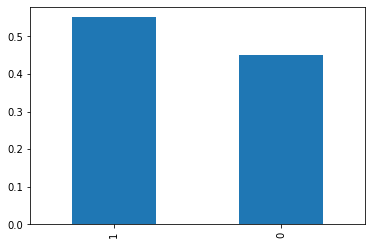

In [42]:
class_frequency = data['at_fault'].value_counts(normalize=True)

print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

В целом это неплохое соотношение, почти ровное, перекоса не вижу.

### Разделим данные на выборки

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['at_fault']), data['at_fault'],
    test_size=0.25, 
    shuffle=True,
    random_state=42)


### Закодируем и стандартизируем данные

In [44]:
warnings.filterwarnings("ignore")

numeric = ['date_part']
categorical = ['weather_1', 'primary_collision_factor', 'road_surface', 'lighting', 'county_location', 'road_condition_1', 'party_sobriety']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse=False, drop='first',handle_unknown = 'error'), categorical)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)
    

print(X_train.shape, X_test.shape)

(18314, 91) (6105, 91)


## Построение моделей для оценки водительского риска

### Случайный лес

In [45]:
%%time 
warnings.filterwarnings("ignore") 

model = RandomForestClassifier()

params = {'n_estimators': range (80, 201, 40), #range (20, 200, 10),
          'max_depth': range (10, 26, 5), #range (1,100, 5),
          'random_state': [42]} 

grid_0 = GridSearchCV(model, params, scoring='recall',n_jobs=-1, cv=5)
grid_0.fit(X_train, y_train)

print(grid_0.best_params_)
print(grid_0.best_score_)

{'max_depth': 10, 'n_estimators': 120, 'random_state': 42}
0.8307636266042063
CPU times: user 2min 21s, sys: 530 ms, total: 2min 21s
Wall time: 2min 22s


### Логиcтическая регрессия

In [62]:
%%time

model = LogisticRegression(random_state=42, max_iter=1000)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
final_score = sum(scores) / len(scores)
final_score

CPU times: user 23.9 s, sys: 25.7 s, total: 49.6 s
Wall time: 49.7 s


0.6842502805836139

In [63]:
%%time

params_grid = {'C':       range(1, 10),
               'penalty': ['l1', 'l2','elasticnet', None]}
  

model = LogisticRegression(random_state=42, max_iter=1000)
grid_log_reg = RandomizedSearchCV(model, params_grid, scoring='recall', cv=5)
grid_log_reg.fit(X_train, y_train)
grid_log_reg.best_score_

CPU times: user 3min 7s, sys: 3min 14s, total: 6min 22s
Wall time: 6min 22s


0.6842502805836139

### Бустинг LGBM

In [64]:
%%time

#подберем параметры для бустинга
warnings.filterwarnings("ignore") 

model = LGBMClassifier()

params = {'n_estimators': range (80, 201, 20), #range (20, 200, 10),
          'max_depth': range (10, 51, 5), #range (1,100, 5),
          'random_state': [42]} #'learning_rate': range (),

grid_1 = GridSearchCV(model, params, scoring='recall',n_jobs=-1, cv=5)
grid_1.fit(X_train, y_train)

print(grid_1.best_params_)
print(grid_1.best_score_)

{'max_depth': 10, 'n_estimators': 80, 'random_state': 42}
0.6669635973259161
CPU times: user 3min 30s, sys: 1.25 s, total: 3min 31s
Wall time: 3min 32s


### Бустинг CatBoostClassifier

In [ ]:
%%time 

#подберем параметры для бустинга 

warnings.filterwarnings("ignore") 

model =  CatBoostClassifier()

params = {'iterations': [500],
          'depth': range (1,50, 5),
          'loss_function': ['Logloss'],
          'random_state': [42]} 

grid_2 = RandomizedSearchCV(model,params, scoring='recall', n_jobs=-1,  cv=5)
grid_2.fit(X_train, y_train)

print(grid_2.best_params_)
print(grid_2.best_score_)

Learning rate set to 0.061207
0:	learn: 0.6859242	total: 50.4ms	remaining: 25.2s
1:	learn: 0.6785092	total: 53.6ms	remaining: 13.4s
2:	learn: 0.6723354	total: 56.2ms	remaining: 9.31s
3:	learn: 0.6661427	total: 58.7ms	remaining: 7.28s
4:	learn: 0.6608646	total: 60.9ms	remaining: 6.03s
5:	learn: 0.6556847	total: 63.5ms	remaining: 5.23s
6:	learn: 0.6512620	total: 66ms	remaining: 4.65s
7:	learn: 0.6456112	total: 68.2ms	remaining: 4.19s
8:	learn: 0.6416934	total: 70.5ms	remaining: 3.85s
9:	learn: 0.6382800	total: 72.8ms	remaining: 3.57s
10:	learn: 0.6342298	total: 75.1ms	remaining: 3.34s
11:	learn: 0.6307490	total: 77.6ms	remaining: 3.15s
12:	learn: 0.6281516	total: 79.6ms	remaining: 2.98s
13:	learn: 0.6249885	total: 82.3ms	remaining: 2.86s
14:	learn: 0.6229905	total: 85ms	remaining: 2.75s
15:	learn: 0.6201518	total: 87.4ms	remaining: 2.65s
16:	learn: 0.6184250	total: 89.6ms	remaining: 2.55s
17:	learn: 0.6161462	total: 92ms	remaining: 2.46s
18:	learn: 0.6137818	total: 94.6ms	remaining: 2.39

### Нейронная сеть

In [ ]:
#переведём данные в формат тензоров
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test.values)

In [ ]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 64
n_hidden_neurons = 128
n_out_neurons = 1

num_epochs = 5_000 # количество эпох
batch_size = 1000 # количество батчей
learning_rate = 0.001

In [ ]:
class Net(nn.Module): 
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons)
        self.fc2= nn.Linear(n_hidden_neurons,n_out_neurons)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten(start_dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return self.flatten(x)

In [ ]:
# Объявим функцию learn_net
def learn_net(num_epochs, X_train,y_train,X_test,y_test ):
    """
    Функция обучения нс и выводом графика значений метрики от эпох для двух выборок.
    
    Параметры:
    num_epochs,
    X_train,
    y_train,
    X_test,
    y_test
    
    """
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # создаем Adam оптимизатор
 
    loss = nn.BCELoss()
 
    
    result_for_plot = []
    train_result_for_plot = []
    epoch_for_plot = []


    for epoch in range(num_epochs):
        optimizer.zero_grad()
 
        preds = net.forward(X_train).flatten()
 
        loss_value = loss(preds, y_train)
 
        loss_value.backward()
 
        optimizer.step()
 
        if epoch % 5000 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            pred_temp = test_preds.detach().numpy()
            recall = recall_score(y_test, pred_temp.round())
            result_for_plot.append(recall)
        
            train_preds = net.forward(X_train)
            train_pred_temp = train_preds.detach().numpy()
            train_recall = recall_score(y_train, train_pred_temp.round())
            train_result_for_plot.append(train_recall)
        
        
            epoch_for_plot.append(epoch)
            print(f'train_recall {train_recall}')
        
    plt.plot(epoch_for_plot, result_for_plot)
    plt.plot(epoch_for_plot, train_result_for_plot)
    plt.title('график зависимости recall модели от эпох')
    plt.show()
    
    #return pred_temp
        
            

In [ ]:
%%time 

net = Net(n_in_neurons, n_hidden_neurons,  n_out_neurons)

#применим функцию обучения сети
learn_net(num_epochs, X_train,y_train,X_test,y_test )

### Выводы по обучению моделей

Следующие модели показали следующие результаты: 

 - Случайный лес - 0.837
 - Логистическая регрессия - 0.681
 - LGBMClassifier - 0.675
 - CatBoostClassifier - 
 - Нейронная сеть - 
 
 На данный момент лучший результат показал случайный лес, который дал значение полноты на кросс-валидационной выборке 0.837. Поэтому в дальнейшем разделе тестируется именно эта модель.

### Тестирование лучшей модели

In [46]:
%%time 
# Предскажем результаты на тестовой выборке
predictions_test = grid_0.best_estimator_.predict(X_test)

CPU times: user 108 ms, sys: 8 µs, total: 108 ms
Wall time: 107 ms


Построим матрицу ошибок и посмотрим полноту на тестовых данных

In [47]:
tn_fp, fn_tp = confusion_matrix(y_test, predictions_test, normalize='all')

print(f'True Negative и False Positive{tn_fp}')
print(f'False Negative и True Positive{fn_tp}')


True Negative и False Positive[0.16658477 0.28927109]
False Negative и True Positive[0.08402948 0.46011466]


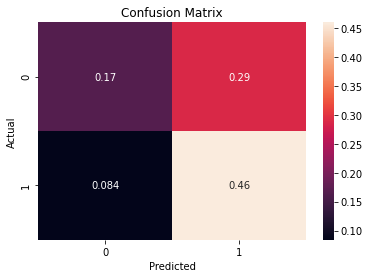

In [48]:
plt.title('Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, predictions_test, normalize='all'), annot=True)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

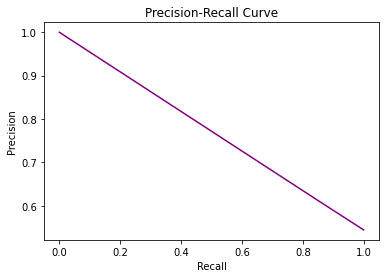

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions_test)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [50]:
recall= recall_score(y_test, predictions_test)
precision= precision_score(y_test, predictions_test)
print(f'Полнота на тестовых данных при пороге 0.5: {recall}')
print(f'Точность на тестовых данных при пороге 0.5: {precision}')

Полнота на тестовых данных при пороге 0.5: 0.845574954846478
Точность на тестовых данных при пороге 0.5: 0.6139890710382514


Посмотрим влияние признаков на модель, узнаем, какой признак наиболее нам полезен

In [54]:
columns_names = col_transformer.get_feature_names_out()

In [55]:
#в порядке возрастания выведем влияние признаков на выбранную модель в процeнтах:
importances = grid_0.best_estimator_.feature_importances_
f_importances = pd.Series(importances, index=columns_names).sort_values(ascending=False) 
print(f_importances)

ohe__party_sobriety_had not been drinking                 0.214043
ohe__primary_collision_factor_vehicle code violation      0.196823
ohe__party_sobriety_had been drinking, under influence    0.186046
ohe__primary_collision_factor_other than driver           0.121254
ohe__primary_collision_factor_unknown                     0.090014
                                                            ...   
ohe__weather_1_other                                      0.000118
ohe__county_location_san benito                           0.000095
ohe__county_location_alpine                               0.000088
ohe__county_location_modoc                                0.000038
ohe__weather_1_wind                                       0.000014
Length: 91, dtype: float64


Для одного из выявленных важных факторов проведём дополнительное исследование:

Построим рафик зависимости фактора и целевой переменной

In [57]:
# напишем запрос
query = '''

SELECT *, (total_dtp - total_fault) AS total_no_fault
FROM (SELECT p.PARTY_SOBRIETY, COUNT(p.at_fault) AS total_dtp, SUM(p.at_fault) AS total_fault
      FROM collisions AS c
      INNER JOIN parties AS p ON c.case_id = p.case_id
      GROUP BY p.PARTY_SOBRIETY) as d

'''

# выполним запрос
fault = pd.read_sql_query(query, con=engine)
fault

,party_sobriety,total_dtp,total_fault,total_no_fault
0,"had been drinking, impairment unknown",21419,17052,4367
1,"had been drinking, not under influence",17650,11944,5706
2,"had been drinking, under influence",112413,105946,6467
3,had not been drinking,2124727,928820,1195907
4,impairment unknown,232901,182724,50177
5,not applicable,169343,12801,156542
6,None,73955,28840,45115


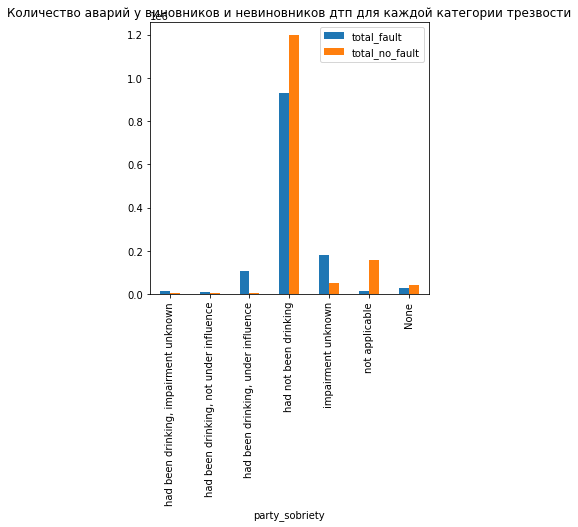

In [61]:
fault[['party_sobriety', 'total_fault', 'total_no_fault']].plot(x='party_sobriety', kind='bar', figsize = (5,5), title = 'Количество аварий у виновников и невиновников дтп для каждой категории трезвости') 
plt.show()

По графику отчетливо видно, что хоть и трезвых аварий больше, но во всех нетрезвых авариях всегда больше виновников, что говорит о важности этого признака.

## Выводы

В данной работе была проверена идея заказчика о построении системы предсказывания ситуации на дороге. На данный момент данные отобраны и очищены для конкретной задачи, выбраны первичные основные признаки и построено несколько вариантов моделей. Выбрана модель случайного леса, которая на кросс-валидационной выборке показала значение recall 0,837. Это значение мало для глобального использования и внедрения данной системы, но оно достаточно велико, чтобы можно было развивать и улучшать систему для её выхода в свет. На тестовых данных значение recall было 0.78. Данные значения обозначены для порога 0.5. 

Для надежной работы сервиса такая модель не подойдет, но она имеет достаточное значение метрики, чтобы не забрасывать проект, поэтому предлагается улучшать данные. Необходимо собрать больше данных о поездке, водителе и автомобиле: возможно можно узнать опыт вождения человека, его страховые истории аварий, количество прошлых аварий, умение ездить на акп и мкп, возможно больше медицинских данных от кардиолога или невролога на случай мигреней или сердечных приступов.Также возможно нужно детальнее рассмотреть устройство машины: в каршерингах машины чаще изнашиваются и есть точечные неполадки с колесами\двигателем\тормозами и так далее. 

## Улучшения

Со стороны технических улучшений проекта можно предложить следующие варианты:

 - Более глубокий отбор признаков и детальная их обработка(например, учитывать признак дня или ночи)
 - Другие методы и модели
 - Другие методы кодирования категориальных признаков